In [1]:
# mount google drive to colab instrance:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# add data3a folder shortcut to drive and copy to colab instance:

!cp -r /content/drive/MyDrive/data3a/ /content/

^C


In [6]:
pip install torchvision

     ---------------------------------------- 1.1/1.1 MB 5.8 MB/s eta 0:00:00
     -------------------------------------- 167.2/167.2 MB 2.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.10.2
    Uninstalling torch-1.10.2:
      Successfully uninstalled torch-1.10.2
Note: you may need to restart the kernel to use updated packages.


In [13]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torchvision
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
import torchvision.models as models
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import random_split
# %matplotlib inline

ImportError: cannot import name 'OpOverloadPacket' from 'torch._ops' (C:\Users\Prajwal Bhamere\anaconda3\lib\site-packages\torch\_ops.py)

In [ ]:
# import pandas as pd
# import os
# l=os.listdir("/kaggle/input/indian-sign-language-isl/Indian/")
# df=pd.DataFrame({"path":[],"label":[]})
# # s=os.listdir("/kaggle/input/indian-sign-language-isl/Indian/")
# for clas in l:
#     s="/kaggle/input/indian-sign-language-isl/Indian/{}".format(clas)
#     imgpath=os.listdir(s)
#     print("class:",clas)
    
#     for i in imgpath:
#         tdf=pd.DataFrame({"path":[s+"/"+i],"label":[clas]})
# #         print(tdf)
#         df=df.append(tdf,ignore_index=True)
# #         print("df:\n",df)

In [46]:
from torchvision.datasets import ImageFolder

train_data_dir="C:\Users\Prajwal Bhamere\Projects\STC\car-damage-dataset\data3a\training"
val_data_dir="C:\Users\Prajwal Bhamere\Projects\STC\car-damage-dataset\data3a\validation

transformer = torchvision.transforms.Compose(
    [  # Applying Augmentation
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation(40),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]
        ),
    ]
)

train_database = ImageFolder(train_data_dir, transform=transformer)
val_database=ImageFolder(val_data_dir, transform=transformer)

# train_database = ImageFolder(train_data_dir)
# val_database=ImageFolder(val_data_dir)

In [4]:
train_database

Dataset ImageFolder
    Number of datapoints: 979
    Root location: /content/drive/MyDrive/data3a/training/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-40.0, 40.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
           )

In [5]:
train_database.classes

['01-minor', '02-moderate', '03-severe']

In [6]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=5).permute(1, 2, 0))
        # ax.imshow(make_grid(images, nrow=5))
        break

def show_sample(image, label):
    print("Label :" +train_database.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))
    # plt.imshow(image)

Label :01-minor(0)


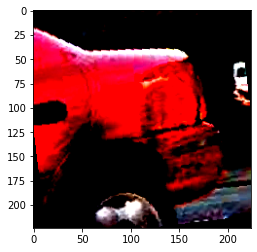

In [7]:
show_sample(*train_database[5]) #just to check if data is getting loaded properly

In [ ]:
# validation_size=3000
# training_size=42745-validation_size
# print(training_size)
# train_ds, val_ds_main = random_split(database,[training_size, validation_size])
# val_ds, test_ds  = random_split(val_ds_main,[1500, 1500])
# len(train_ds), len(val_ds)

In [47]:
batch_size=30
train_dl = DataLoader(train_database, batch_size , shuffle=True)
val_dl = DataLoader(val_database,batch_size)
# test_dl = DataLoader(test_ds, batch_size)

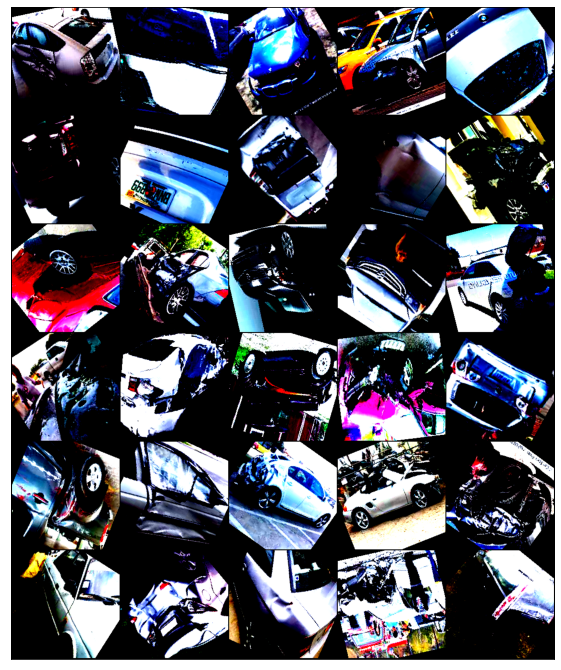

In [9]:

show_batch(train_dl)

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = torch.nn.functional.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = torch.nn.functional.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [19]:

class HandsignModel(ImageClassification):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.regnet_y_128gf(pretrained=True, weights = [RegNet_Y_128GF_Weights])
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 3)
        
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [20]:
model = HandsignModel()
model

NameError: ignored

In [11]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=756901a6515e661b3baea4c6487322eb5929206e526801aedb75a8eee95fb921
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
Successfully built efficientnet-pytorch


In [49]:
import torch.nn.functional as F
class FlowerClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [50]:
# from torchvision.models import inception_v3 
class FlowerModel18(FlowerClassification): 
    def __init__(self): 
        super(FlowerModel18, self).__init__() 
        self.resnet = EfficientNet.from_pretrained('efficientnet-b0')
        self.l1 = nn.Linear(1000 , 256) 
        self.dropout = nn.Dropout(0.75) 
        self.l2 = nn.Linear(256,3) 
        self.relu = nn.ReLU()

    def forward(self, xb):
        x = self.resnet(xb)
        x = x.view(x.size(0),-1)
        x = self.dropout(self.relu(self.l1(x)))
        x = self.l2(x)
        return x

In [56]:
model = to_device(FlowerModel18(), device)
evaluate(model, val_dl)

Loaded pretrained weights for efficientnet-b0


RuntimeError: ignored

In [35]:
for images, labels in train_dl:
    images, labels = images.cuda(), labels.cuda() 
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([30, 3, 224, 224])
out.shape: torch.Size([30, 3])
out[0]: tensor([ 0.4548, -0.4429,  0.1233], device='cuda:0', grad_fn=<SelectBackward0>)


In [52]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [53]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [54]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [55]:
device=get_default_device()
device

device(type='cuda')

In [24]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [57]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)


FlowerModel18(
  (resnet): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddin

In [43]:
num_epochs = 50
opt_func = torch.optim.Adam
lr = 0.001

In [59]:
op=fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.0893, val_loss: 1.0798, val_acc: 0.4278
Epoch [1], train_loss: 1.0898, val_loss: 1.0799, val_acc: 0.4278


KeyboardInterrupt: ignored

In [ ]:
torch.save(model,'/content/drive/MyDrive/indian-sign-language-cnn.pth')

In [ ]:
label_dict={0:'01-minor',1:'02-moderate', 2:'03-severe'}


In [ ]:
def predict(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return label_dict[preds[0].item()]

label: 0
Label: 01-minor , Predicted: 01-minor


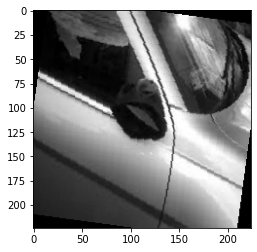

In [ ]:
img, label = train_database[15]
print("label:",label)
model.to("cpu")

plt.imshow(img[0], cmap='gray')
# predict(img, model)
print('Label:', train_database.classes[label], ', Predicted:', predict(img, model))